# ConvNext training complete pipeline

## 0. Import libraries

In [113]:
import os
from pathlib import Path
from typing import List, Tuple
from shutil import copy2
from PIL import Image

import cv2
import numpy as np
import pandas as pd
import torch as pt
import torch.nn as nn
import matplotlib.pyplot as plt
import torchvision.transforms as T
from tqdm import tqdm
from torch.utils.data import DataLoader, Dataset, WeightedRandomSampler
from torchvision.models import convnext_tiny, ConvNeXt_Tiny_Weights
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, f1_score

# Try to import Lion optimizer
try:
    from lion_pytorch import Lion
    print("✅ Lion optimizer available")
except ImportError:
    print("⚠️ Installing Lion optimizer...")
    !pip install lion-pytorch
    from lion_pytorch import Lion
    print("✅ Lion optimizer installed")

%matplotlib inline

# select device
if pt.cuda.is_available():
    device = 'cuda'
elif pt.backends.mps.is_available():
    device = 'mps'
else:
    device = 'cpu'


print(f"Pytorch version: {pt.__version__}")
print(f"Using device: {device}")
print(f"OpenCV version: {cv2.__version__}")

✅ Lion optimizer available
Pytorch version: 2.9.1
Using device: mps
OpenCV version: 4.12.0


In [19]:
RANDOM_SEED = 42

In [20]:
def set_seed(seed: int = 42) -> None:
    """Set seed for reproducibility."""
    np.random.seed(seed)
    pt.manual_seed(seed)
    if pt.cuda.is_available():
        pt.cuda.manual_seed(seed)
        pt.cuda.manual_seed_all(seed)
    elif pt.backends.mps.is_available():
        pt.mps.manual_seed(seed)

In [21]:
set_seed(RANDOM_SEED)

## 1. Dataset Preprocessing

We have to filter out shrek and goo artifacts from dataset. Use masks by cropping the images to the masks bounding box and then apply patching technique and create multiple images from one image, use 128x128 imsize for the patches.

In [3]:
MAX_ARTIFACT_RATIO = 0.005  # Maximum allowed artifact ratio
ROOT_DATA_DIR = '../data'
INPUT_DIR = os.path.join(ROOT_DATA_DIR, 'train_data')
TRAIN_LABELS = os.path.join(ROOT_DATA_DIR, 'train_labels.csv')
FILTERED_IMAGES = os.path.join(ROOT_DATA_DIR, 'train_data_filtered')
OUTPUT_DIR = os.path.join(ROOT_DATA_DIR, 'train_data_preprocessed')

In [4]:
train_labels_df = pd.read_csv(TRAIN_LABELS)
print(f"Loaded {len(train_labels_df)} training labels.")

Loaded 691 training labels.


### 1.1 Filter out shrek and goo

In [5]:
def detect_artifacts(image_path, max_artifact_ratio=0.005):
    """
    Detect artifacts using color-based filtering.
    Returns True if image is clean enough, False otherwise.
    """
    img = cv2.imread(image_path)
    if img is None:
        return False, "Failed to load"
    
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    
    # Define artifact color ranges
    # Green markers
    lower_green = np.array([25, 40, 40])
    upper_green = np.array([95, 255, 255])
    
    # Orange markers
    lower_orange = np.array([5, 50, 50])
    upper_orange = np.array([35, 255, 255])
    
    # White centers
    lower_white = np.array([0, 0, 200])
    upper_white = np.array([180, 30, 255])
    
    # Brown markers
    lower_brown = np.array([0, 60, 20])
    upper_brown = np.array([25, 255, 150])
    
    # Detect all artifacts
    mask_green = cv2.inRange(hsv, lower_green, upper_green)
    mask_orange = cv2.inRange(hsv, lower_orange, upper_orange)
    mask_white = cv2.inRange(hsv, lower_white, upper_white)
    mask_brown = cv2.inRange(hsv, lower_brown, upper_brown)
    
    # Combine all artifact masks
    artifacts = cv2.bitwise_or(mask_green, mask_orange)
    artifacts = cv2.bitwise_or(artifacts, mask_white)
    artifacts = cv2.bitwise_or(artifacts, mask_brown)
    
    # Calculate artifact ratio
    total_pixels = img.shape[0] * img.shape[1]
    artifact_pixels = cv2.countNonZero(artifacts)
    artifact_ratio = artifact_pixels / total_pixels
    
    # Accept if artifact ratio is below threshold
    if artifact_ratio > max_artifact_ratio:
        return False, f"Too many artifacts ({artifact_ratio:.2%})"
    
    return True, f"Clean ({artifact_ratio:.2%} artifacts)"

In [6]:
filtered_images_path = Path(FILTERED_IMAGES)
filtered_images_path.mkdir(parents=True, exist_ok=True)

image_files = train_labels_df["sample_index"].to_list()
filtered_image_files = []

for img_file in tqdm(image_files):
    img_path = Path(INPUT_DIR) / img_file
    mask_path = Path(INPUT_DIR) / img_file.replace('img_', 'mask_')
    is_clean, msg = detect_artifacts(str(img_path), max_artifact_ratio=MAX_ARTIFACT_RATIO)
    if is_clean:
        dest_path = filtered_images_path / img_file
        dest_mask_path = filtered_images_path / img_file.replace('img_', 'mask_')
        copy2(img_path, dest_path)
        copy2(mask_path, dest_mask_path)
        filtered_image_files.append(img_file)

print(f"Filtered images saved to {FILTERED_IMAGES}. {len(filtered_image_files)} clean images found out of {len(image_files)}.")

100%|██████████| 691/691 [00:14<00:00, 47.70it/s]

Filtered images saved to ../data/train_data_filtered. 547 clean images found out of 691.


In [7]:
train_labels_df_filtered = train_labels_df[train_labels_df["sample_index"].isin(filtered_image_files)]
print(f"Filtered training labels: {len(train_labels_df_filtered)} entries.")
train_labels_df_filtered.to_csv(os.path.join(ROOT_DATA_DIR, 'train_labels_filtered.csv'), index=False)

Filtered training labels: 547 entries.


### 2. Augment data by patching

In [8]:
PATCH_SIZE = 128

In [9]:
def crop_image(image: np.ndarray, mask: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
    """
    Crop image to mask bounding box.
    """
    # Find countours in the mask
    x_coords, y_coords = np.where(mask > 0) 

    # Get bounding box coordinates
    x_min, x_max = np.min(x_coords), np.max(x_coords)
    y_min, y_max = np.min(y_coords), np.max(y_coords)
    
    # Crop image and mask
    cropped_image = image[x_min:x_max+1, y_min:y_max+1]
    cropped_mask = mask[x_min:x_max+1, y_min:y_max+1]
    
    return cropped_image, cropped_mask
    

def extract_patches(image: np.ndarray, mask: np.ndarray, patch_size: int, overlap: int) -> List[Tuple[np.ndarray, np.ndarray]]:
    """
    Extract patches with overlap, handling edges by ensuring full coverage.
    """
    patches = []
    img_height, img_width = image.shape[:2]
    stride = patch_size - overlap

    # Calculate positions (ensuring we capture edges)
    y_positions = list(range(0, img_height - patch_size + 1, stride))
    x_positions = list(range(0, img_width - patch_size + 1, stride))
    
    # Add edge positions if not already included
    if img_height >= patch_size:
        if y_positions[-1] != img_height - patch_size:
            y_positions.append(img_height - patch_size)
    else:
        y_positions = [0]
    if img_width >= patch_size:
        if x_positions[-1] != img_width - patch_size:
            x_positions.append(img_width - patch_size)
    else:
        x_positions = [0]
    
    # Extract patches
    for i in y_positions:
        for j in x_positions:
            if img_height < patch_size:
                i_end = img_height
            else:
                i_end = i + patch_size    
            if img_width < patch_size:
                j_end = img_width
            else:
                j_end = j + patch_size
            img_patch = image[i:i_end, j:j_end]
            mask_patch = mask[i:i_end, j:j_end]
            
            # Skip patches with insufficient tissue
            if np.count_nonzero(mask_patch) < 0.1 * patch_size * patch_size:
                continue
            
            patches.append((img_patch, mask_patch))
    
    return patches
    

In [39]:
output_dir_path = Path(OUTPUT_DIR)
output_dir_path.mkdir(parents=True, exist_ok=True)

n_patches = 0

rows = {}

filtered_image_files = train_labels_df_filtered["sample_index"].to_list()
filtered_image_labels  = train_labels_df_filtered["label"].to_list()

for img_file, label in tqdm(zip(filtered_image_files, filtered_image_labels), total=len(filtered_image_files)):
    img_path = Path(FILTERED_IMAGES) / img_file
    mask_path = Path(FILTERED_IMAGES) / img_file.replace('img_', 'mask_')
    
    # Load image and mask
    image = cv2.imread(str(img_path))
    mask = cv2.imread(str(mask_path), cv2.IMREAD_GRAYSCALE)
    
    # Crop to bounding box
    cropped_image, cropped_mask = crop_image(image, mask)
    
    # Extract patches
    patches = extract_patches(cropped_image, cropped_mask, PATCH_SIZE, overlap=32)
    
    # Save patches
    base_name = img_file.replace('img_', '').replace('.png', '')
    for idx, (img_patch, mask_patch) in enumerate(patches):
        patch_img_path = Path(OUTPUT_DIR) / f"img_{base_name}_patch{idx:03d}.png"
        patch_mask_path = Path(OUTPUT_DIR) / f"mask_{base_name}_patch{idx:03d}.png"
        cv2.imwrite(str(patch_img_path), img_patch)
        cv2.imwrite(str(patch_mask_path), mask_patch)
        rows[f"img_{base_name}_patch{idx:03d}.png"] = label
    n_patches += len(patches)

print(f"Preprocessed patches saved to {OUTPUT_DIR}. Total patches extracted: {n_patches}.")

100%|██████████| 547/547 [00:14<00:00, 38.71it/s]

Preprocessed patches saved to ../data/train_data_preprocessed. Total patches extracted: 4417.


In [44]:
rows

{'img_0000_patch000.png': 'Triple negative',
 'img_0002_patch000.png': 'Luminal B',
 'img_0002_patch001.png': 'Luminal B',
 'img_0002_patch002.png': 'Luminal B',
 'img_0002_patch003.png': 'Luminal B',
 'img_0003_patch000.png': 'Luminal B',
 'img_0003_patch001.png': 'Luminal B',
 'img_0003_patch002.png': 'Luminal B',
 'img_0003_patch003.png': 'Luminal B',
 'img_0003_patch004.png': 'Luminal B',
 'img_0004_patch000.png': 'Luminal B',
 'img_0004_patch001.png': 'Luminal B',
 'img_0006_patch000.png': 'Luminal A',
 'img_0006_patch001.png': 'Luminal A',
 'img_0006_patch002.png': 'Luminal A',
 'img_0006_patch003.png': 'Luminal A',
 'img_0007_patch000.png': 'Luminal B',
 'img_0007_patch001.png': 'Luminal B',
 'img_0009_patch000.png': 'Luminal B',
 'img_0009_patch001.png': 'Luminal B',
 'img_0009_patch002.png': 'Luminal B',
 'img_0009_patch003.png': 'Luminal B',
 'img_0009_patch004.png': 'Luminal B',
 'img_0009_patch005.png': 'Luminal B',
 'img_0009_patch006.png': 'Luminal B',
 'img_0009_patch007

In [48]:
train_labels_patches = pd.DataFrame(rows.items(), columns=['sample_index', 'label'])
train_labels_patches.to_csv(os.path.join(ROOT_DATA_DIR, 'train_labels_preprocessed_patches.csv'), index=False)

In [49]:
train_labels_patches.head()

,sample_index,label
0,img_0000_patch000.png,Triple negative
1,img_0002_patch000.png,Luminal B
2,img_0002_patch001.png,Luminal B
3,img_0002_patch002.png,Luminal B
4,img_0002_patch003.png,Luminal B


## 3. Training

### 3.1 Dataset class setup

In [80]:
class ConvNeXtDataset(Dataset):
    def __init__(self, image_dir: str, labels_df: pd.DataFrame, transform=None):
        self.image_dir = Path(image_dir)
        self.labels_df = labels_df.set_index('sample_index')
        self.transform = transform
        self.image_files = list(self.labels_df.index)
        self.class_names = self.labels_df['label'].unique().tolist()

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_file = self.image_files[idx]
        img_path = self.image_dir / img_file
        image = Image.open(img_path).convert('RGB')
        
        label = self.labels_df.loc[img_file, 'label']
        class_num = self.class_names.index(label)
        
        if self.transform:
            image = self.transform(image)
        
        return image, class_num

### 3.2 Transformations

In [67]:
# Configuration
IMG_SIZE = 128
BATCH_SIZE = 32  # Larger for BatchNorm stability (Advice 04/12)
NUM_WORKERS = 0

# Training transforms with RandAugment (Advice 06/12)
train_transform = T.Compose([
    T.Resize((IMG_SIZE, IMG_SIZE)),
    T.RandomHorizontalFlip(p=0.5),
    T.RandomVerticalFlip(p=0.5),
    T.RandomRotation(degrees=15),
    T.RandAugment(num_ops=2, magnitude=7),  # Automated augmentation
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Validation transforms (no augmentation)
val_transform = T.Compose([
    T.Resize((IMG_SIZE, IMG_SIZE)),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

### 3.3 Set up datasets and dataloaders

#### Split dataset to train and validation set

In [68]:
train_df, val_df = train_test_split(
    train_labels_patches, 
    test_size=0.2,
    random_state=RANDOM_SEED,
    stratify=train_labels_patches['label']
)

train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)

print(f"Training samples: {len(train_df)}, Validation samples: {len(val_df)}")

Training samples: 3533, Validation samples: 884


In [69]:
train_df.head()

,sample_index,label
0,img_0013_patch007.png,HER2(+)
1,img_0103_patch002.png,Luminal A
2,img_0689_patch002.png,Luminal A
3,img_0351_patch000.png,Luminal A
4,img_0236_patch001.png,Luminal B


### Calculate class weights

In [70]:
class_counts = train_df['label'].value_counts()
class_counts

label
Luminal B          1315
Luminal A           942
HER2(+)             906
Triple negative     370
Name: count, dtype: int64

In [71]:
class_weights = {label: 1.0/count for label, count in class_counts.items()}
sample_weights = train_df['label'].map(class_weights).values
sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)

### Create dataset objects and dataloaders

In [84]:
train_ds = ConvNeXtDataset(
    image_dir=OUTPUT_DIR, labels_df=train_df, transform=train_transform
)
val_ds = ConvNeXtDataset(
    image_dir=OUTPUT_DIR, labels_df=val_df, transform=val_transform
)

In [88]:
train_ds[0][0].size()

torch.Size([3, 128, 128])

In [89]:
train_dl = DataLoader(
    train_ds,
    batch_size=BATCH_SIZE,
    sampler=sampler,
    num_workers=NUM_WORKERS,
    pin_memory=True
)
val_dl = DataLoader(
    val_ds,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=True
)

## 4 Model Setup

In [106]:
model = convnext_tiny(weights=ConvNeXt_Tiny_Weights.IMAGENET1K_V1)

print(model.classifier)

# Modify the final layer for our number of classes
num_classes = len(train_ds.class_names)
model.classifier[2] = nn.Linear(in_features=768, out_features=num_classes)

model.to(device)

Sequential(
  (0): LayerNorm2d((768,), eps=1e-06, elementwise_affine=True)
  (1): Flatten(start_dim=1, end_dim=-1)
  (2): Linear(in_features=768, out_features=1000, bias=True)
)


ConvNeXt(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
      (1): LayerNorm2d((96,), eps=1e-06, elementwise_affine=True)
    )
    (1): Sequential(
      (0): CNBlock(
        (block): Sequential(
          (0): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
          (1): Permute()
          (2): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
          (3): Linear(in_features=96, out_features=384, bias=True)
          (4): GELU(approximate='none')
          (5): Linear(in_features=384, out_features=96, bias=True)
          (6): Permute()
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
      )
      (1): CNBlock(
        (block): Sequential(
          (0): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
          (1): Permute()
          (2): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
          (3): Linear(in_features=

In [107]:
# Loss with label smoothing
criterion = nn.CrossEntropyLoss(label_smoothing=0)

# Lion optimizer (Advice 07/12)
# Lion needs 3-10x smaller LR than Adam
optimizer = Lion(model.parameters(), lr=3e-4, weight_decay=1e-2)

# Cosine annealing scheduler
scheduler = pt.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50, eta_min=1e-6)

## 5. Training loop

### Training function definitions

In [108]:
def train_one_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct_preds = 0
    total_samples = 0

    for images, labels in tqdm(dataloader, desc="Training", leave=False):
        images = images.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)
        _, preds = pt.max(outputs, 1)
        correct_preds += (preds == labels).sum().item()
        total_samples += images.size(0)
    
    epoch_loss = running_loss / total_samples
    epoch_acc = correct_preds / total_samples
    epoch_f1 = f1_score(labels.cpu(), preds.cpu(), average='macro')
    return epoch_loss, epoch_acc, epoch_f1

def validate_one_epoch(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct_preds = 0
    total_samples = 0
    
    with pt.no_grad():
        for images, labels in tqdm(dataloader, desc="Validation", leave=False):
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * images.size(0)
            _, preds = pt.max(outputs, 1)
            correct_preds += (preds == labels).sum().item()
            total_samples += images.size(0)
            
    epoch_loss = running_loss / total_samples
    epoch_acc = correct_preds / total_samples
    epoch_f1 = f1_score(labels.cpu(), preds.cpu(), average='macro')
    return epoch_loss, epoch_acc, epoch_f1

### Training configuration

In [109]:
NUM_EPOCHS = 3
WARMUP_EPOCHS = 3
PATIENCE = 10

# Freeze backbone for initial epochs
for param in model.features.parameters():
    param.requires_grad = False

In [110]:
print("FROZEN PARAMETERS:")
for name, param in model.named_parameters():
    if not param.requires_grad:
        print(name)

print("TRAINABLE PARAMETERS:")
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name)

FROZEN PARAMETERS:
features.0.0.weight
features.0.0.bias
features.0.1.weight
features.0.1.bias
features.1.0.layer_scale
features.1.0.block.0.weight
features.1.0.block.0.bias
features.1.0.block.2.weight
features.1.0.block.2.bias
features.1.0.block.3.weight
features.1.0.block.3.bias
features.1.0.block.5.weight
features.1.0.block.5.bias
features.1.1.layer_scale
features.1.1.block.0.weight
features.1.1.block.0.bias
features.1.1.block.2.weight
features.1.1.block.2.bias
features.1.1.block.3.weight
features.1.1.block.3.bias
features.1.1.block.5.weight
features.1.1.block.5.bias
features.1.2.layer_scale
features.1.2.block.0.weight
features.1.2.block.0.bias
features.1.2.block.2.weight
features.1.2.block.2.bias
features.1.2.block.3.weight
features.1.2.block.3.bias
features.1.2.block.5.weight
features.1.2.block.5.bias
features.2.0.weight
features.2.0.bias
features.2.1.weight
features.2.1.bias
features.3.0.layer_scale
features.3.0.block.0.weight
features.3.0.block.0.bias
features.3.0.block.2.weight

In [114]:
training_history = {
    'train_loss': [],
    'train_f1': [],
    'train_acc': [],
    'val_loss': [],
    'val_f1': [],
    'val_acc': [],
}

best_val_loss = float('inf')
epochs_no_improve = 0

for epoch in range(NUM_EPOCHS):
    if epoch == WARMUP_EPOCHS:
        print("Unfreezing backbone...")
        for param in model.features.parameters():
            param.requires_grad = True
    print(f"Epoch {epoch+1}/{NUM_EPOCHS}")
    train_loss, train_acc, train_f1 = train_one_epoch(model, train_dl, criterion, optimizer, device)
    val_loss, val_acc, val_f1 = validate_one_epoch(model, val_dl, criterion, device)
    scheduler.step()
    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Train F1: {train_f1:.4f}")
    print(f"Val   Loss: {val_loss:.4f}, Val   Acc: {val_acc:.4f}, Val   F1: {val_f1:.4f}")
    training_history['train_loss'].append(train_loss)
    training_history['train_acc'].append(train_acc)
    training_history['train_f1'].append(train_f1)
    training_history['val_loss'].append(val_loss)
    training_history['val_acc'].append(val_acc)
    training_history['val_f1'].append(val_f1)
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_no_improve = 0
        pt.save(model.state_dict(), 'best_model_convnext.pth')
        print("Validation loss improved, model saved.")
    else:
        epochs_no_improve += 1
        print(f"No improvement in validation loss for {epochs_no_improve} epochs.")
        if epochs_no_improve >= PATIENCE:
            print("Early stopping triggered.")
            break

Epoch 1/3


Validation:   0%|          | 0/28 [00:00<?, ?it/s]         /Users/bencegaborpeter/Polimi/AN2DL/Challenges/AN2DL_Image_Classification/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Train Loss: 1.2437, Train Acc: 0.4356, Train F1: 0.6935
Val   Loss: 1.4581, Val   Acc: 0.3382, Val   F1: 0.3965
Validation loss improved, model saved.
Epoch 2/3


Training:   0%|          | 0/111 [00:00<?, ?it/s]/Users/bencegaborpeter/Polimi/AN2DL/Challenges/AN2DL_Image_Classification/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
Validation:   0%|          | 0/28 [00:00<?, ?it/s]         /Users/bencegaborpeter/Polimi/AN2DL/Challenges/AN2DL_Image_Classification/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Train Loss: 1.2250, Train Acc: 0.4639, Train F1: 0.3750
Val   Loss: 1.4473, Val   Acc: 0.3326, Val   F1: 0.4582
Validation loss improved, model saved.
Epoch 3/3


Training:   0%|          | 0/111 [00:00<?, ?it/s]/Users/bencegaborpeter/Polimi/AN2DL/Challenges/AN2DL_Image_Classification/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
Validation:   0%|          | 0/28 [00:00<?, ?it/s]         /Users/bencegaborpeter/Polimi/AN2DL/Challenges/AN2DL_Image_Classification/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
                                                           

Train Loss: 1.2120, Train Acc: 0.4594, Train F1: 0.2458
Val   Loss: 1.4874, Val   Acc: 0.2975, Val   F1: 0.2659
No improvement in validation loss for 1 epochs.


### Training curves

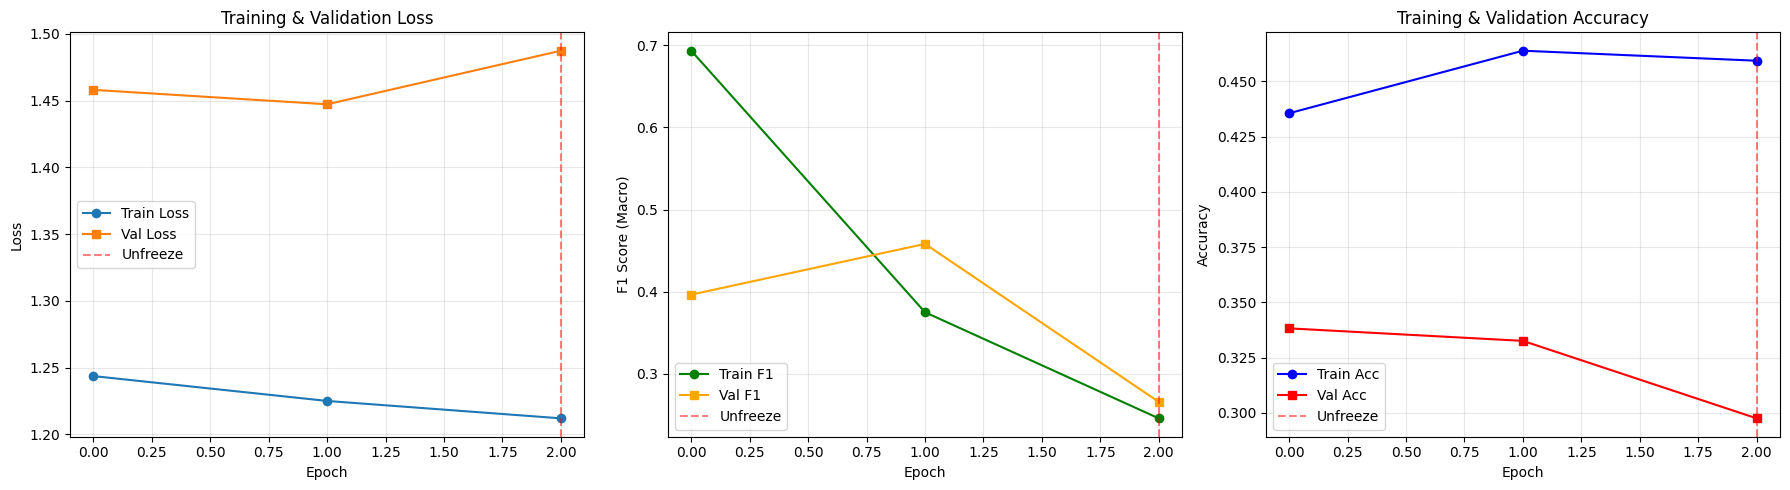

Training curves saved to '../training_curves.png'


In [115]:
# Plot training curves
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Loss
axes[0].plot(training_history['train_loss'], label='Train Loss', marker='o')
axes[0].plot(training_history['val_loss'], label='Val Loss', marker='s')
axes[0].axvline(x=WARMUP_EPOCHS-1, color='r', linestyle='--', alpha=0.5, label='Unfreeze')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training & Validation Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# F1 Score
axes[1].plot(training_history['train_f1'], label='Train F1', marker='o', color='green')
axes[1].plot(training_history['val_f1'], label='Val F1', marker='s', color='orange')
axes[1].axvline(x=WARMUP_EPOCHS-1, color='r', linestyle='--', alpha=0.5, label='Unfreeze')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('F1 Score (Macro)')
# axes[1].set_title(f'F1 Score (Best: {best_f1:.4f})')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Accuracy
axes[2].plot(training_history['train_acc'], label='Train Acc', marker='o', color='blue')
axes[2].plot(training_history['val_acc'], label='Val Acc', marker='s', color='red')
axes[2].axvline(x=WARMUP_EPOCHS-1, color='r', linestyle='--', alpha=0.5, label='Unfreeze')
axes[2].set_xlabel('Epoch')
axes[2].set_ylabel('Accuracy')
axes[2].set_title('Training & Validation Accuracy')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../training_curves.png', dpi=150, bbox_inches='tight')
plt.show()

print("Training curves saved to '../training_curves.png'")

Evaluating:   0%|          | 0/28 [00:00<?, ?it/s]/Users/bencegaborpeter/Polimi/AN2DL/Challenges/AN2DL_Image_Classification/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
Evaluating: 100%|██████████| 28/28 [00:03<00:00,  8.39it/s]


Classification Report:
                 precision    recall  f1-score   support

      Luminal B       0.35      0.13      0.19       329
      Luminal A       0.42      0.56      0.48       235
        HER2(+)       0.26      0.32      0.29       227
Triple negative       0.28      0.51      0.36        93

       accuracy                           0.33       884
      macro avg       0.33      0.38      0.33       884
   weighted avg       0.34      0.33      0.31       884



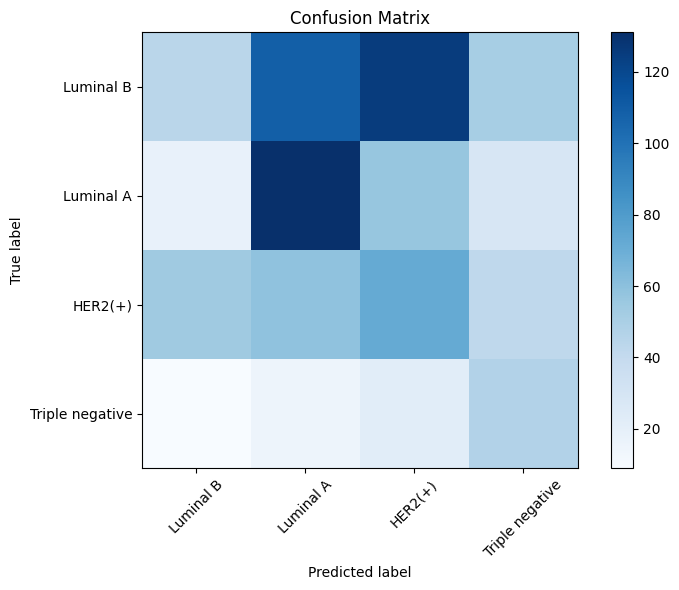

Confusion matrix saved to '../confusion_matrix.png'


In [116]:
model.load_state_dict(pt.load('best_model_convnext.pth'))
model.to(device)
model.eval()

all_preds = []
all_labels = []

with pt.no_grad():
    for images, labels in tqdm(val_dl, desc="Evaluating"):
        images = images.to(device)
        labels = labels.to(device)
        
        outputs = model(images)
        _, preds = pt.max(outputs, 1)
        
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        
# Classification report
report = classification_report(all_labels, all_preds, target_names=val_ds.class_names)
print("Classification Report:")
print(report)

# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(val_ds.class_names))
plt.xticks(tick_marks, val_ds.class_names, rotation=45)
plt.yticks(tick_marks, val_ds.class_names)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.savefig('../confusion_matrix.png', dpi=150, bbox_inches='tight')
plt.show()
print("Confusion matrix saved to '../confusion_matrix.png'")

## 6. Run inference on test set
Use patch based inference and do majority voting

### Process test set to create patches

In [118]:
TEST_DATA_DIR = os.path.join(ROOT_DATA_DIR, 'test_data')
test_image_files = sorted(os.listdir(TEST_DATA_DIR))

In [ ]:
row = {}

for img_file in tqdm(test_image_files, total=len(test_image_files)):
    if img_file == '.DS_Store':
        continue

    if not img_file.startswith('img_'):
        continue

    img_path = Path(TEST_DATA_DIR) / img_file
    mask_path = Path(TEST_DATA_DIR) / img_file.replace('img_', 'mask_')
    
    # Load image and mask
    image = cv2.imread(str(img_path))
    mask = cv2.imread(str(mask_path), cv2.IMREAD_GRAYSCALE)
    
    # Crop to bounding box
    cropped_image, cropped_mask = crop_image(image, mask)
    
    # Extract patches
    patches = extract_patches(cropped_image, cropped_mask, PATCH_SIZE, overlap=32)
    
    # Run inference to get labels
    labels = []

    for idx, (img_patch, mask_patch) in enumerate(patches):
        # Preprocess patch
        pil_img = Image.fromarray(cv2.cvtColor(img_patch, cv2.COLOR_BGR2RGB))
        input_tensor = val_transform(pil_img).unsqueeze(0).to(device)
        
        with pt.no_grad():
            outputs = model(input_tensor)
            _, pred = pt.max(outputs, 1)
            labels.append(val_ds.class_names[pred.item()])
        
    # Majority voting
    if labels:
        final_label = max(set(labels), key=labels.count)
    else:
        final_label = "unknown"
    
    row[img_file] = final_label

submission_df = pd.DataFrame(row.items(), columns=['sample_index', 'label'])
submission_df.to_csv('../submission_convnext.csv', index=False)
print("Submission file saved to '../submission_convnext.csv'")

 27%|██▋       | 256/954 [00:25<01:08, 10.13it/s]


KeyboardInterrupt: 